In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
from model import Model
from options import get_options
from place_cells import PlaceCells

Using TensorFlow backend.


In [4]:
def load_checkpoints(sess):
    saver = tf.train.Saver(max_to_keep=2)
    save_dir = "./saved"
    checkpoint_dir = save_dir + "/checkpoints_seq_100_batch_200_lr_1e2"
    
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)

In [5]:
flags = get_options()
model = Model(flags)

sess = tf.Session()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())
load_checkpoints(sess)

INIT POS SHAPE = Tensor("model/concat:0", shape=(?, 2), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
INFO:tensorflow:Restoring parameters from ./saved/checkpoints_seq_100_batch_200_lr_1e2/checkpoint-77999


## Visualize batch

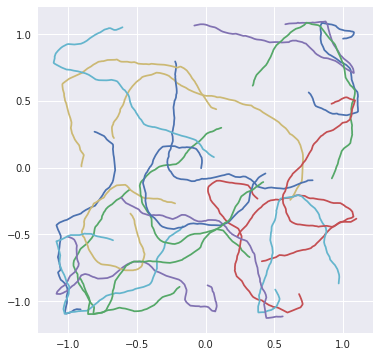

In [6]:
pos_batch = sess.run(model.target_pos)
plt.figure(figsize=(6,6))
for i in range(20):
    plt.plot(pos_batch[i, :, 0], pos_batch[i, :, 1])

## Visualize head direction

In [7]:
import utils

# Prepare ensembles
place_cell_ensembles = utils.get_place_cell_ensembles(
    env_size=2.2,
    neurons_seed=8341,
    targets_type='softmax',
    lstm_init_type='softmax',
    n_pc=[flags.num_place_cells],
    pc_scale=[flags.place_cell_rf])

head_direction_ensembles = utils.get_head_direction_ensembles(
    neurons_seed=8341,
    targets_type='softmax',
    lstm_init_type='softmax',
    n_hdc=[flags.num_hd_cells],
    hdc_concentration=[flags.hd_cell_rf])

In [8]:
target_hd, hd_outputs_pred = sess.run([model.target_hd, model.hd_outputs_result])
hd_outputs_pred = hd_outputs_pred.reshape([flags.batch_size, flags.sequence_length, -1])

In [9]:
def get_true_hd(hd_outputs):
    true_hd = np.zeros(len(hd_outputs))
    for i in range(len(hd_outputs)):
        max_idx = np.argmax(hd_outputs[i])
        true_hd[i] = head_direction_ensembles[0].means[max_idx]
        
    return true_hd

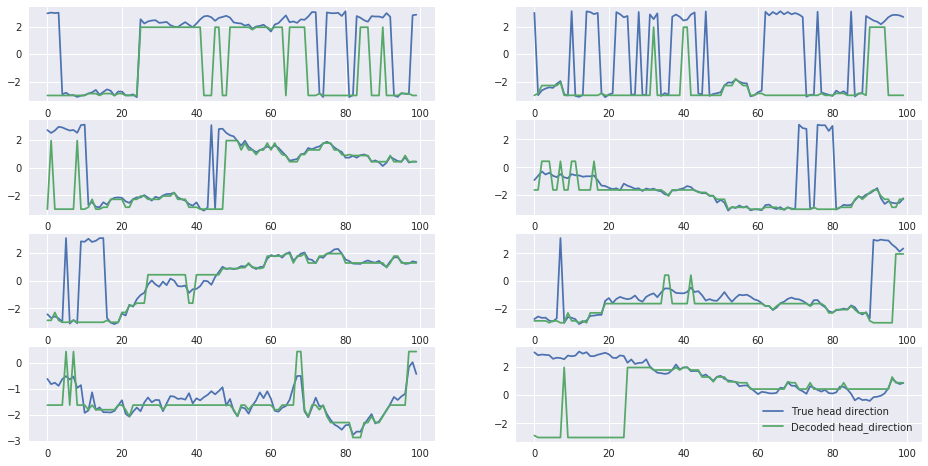

In [10]:
plt.figure(figsize=(16,8))

for i in range(8):
    plt.subplot(4,2,i+1)
    true_hd = get_true_hd(hd_outputs_pred[i])
    plt.plot(target_hd[i,:], label='True head direction')
    plt.plot(true_hd[:], label='Decoded head_direction')
#     plt.xlim([-1.5,1.5])
#     plt.ylim([-1.5,1.5])
plt.legend()

## Visualize trajectory

In [11]:
target_pos, place_outputs_pred = sess.run([model.target_pos, model.place_outputs_result])
place_outputs_pred = place_outputs_pred.reshape([flags.batch_size, flags.sequence_length, -1])

In [12]:
def get_true_pos(place_outputs):
    true_pos = np.zeros([len(place_outputs), 2])
    for i in range(len(place_outputs)):
        max_idx = np.argmax(place_outputs[i])
        true_pos[i] = place_cell_ensembles[0].means[max_idx]
        
    return true_pos

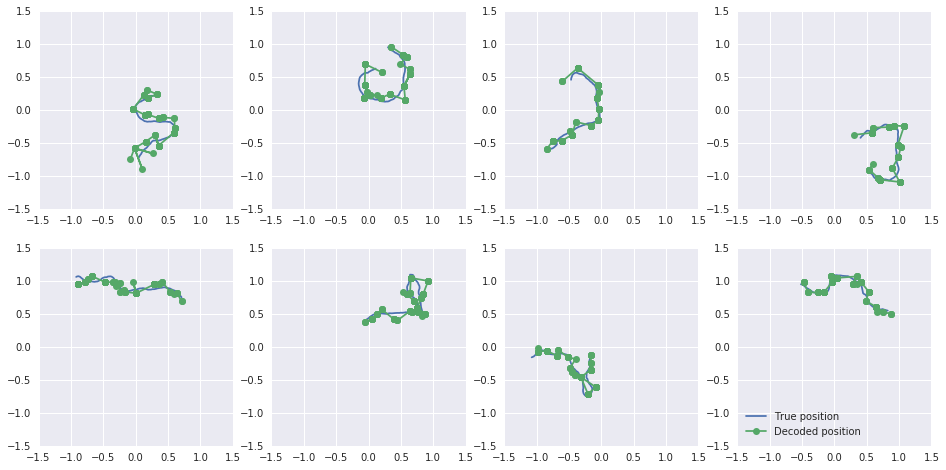

In [13]:
plt.figure(figsize=(16,8))

for i in range(8):
    plt.subplot(2,4,i+1)
    true_pos = get_true_pos(place_outputs_pred[i])
    plt.plot(target_pos[i,:,0], target_pos[i,:,1], label='True position')
    plt.plot(true_pos[:,0], true_pos[:,1], 'o-', label='Decoded position')
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
plt.legend()

# RNN states

In [ ]:
index_size= 100
resolution = 50
maze_extents = 1.1

activations = np.zeros([128, resolution, resolution], dtype=np.float32) # (512, 32, 32)
counts  = np.zeros([resolution, resolution], dtype=np.int32)        # (32, 32)

# Stash activations and positions for later
rnn = np.zeros([index_size, flags.batch_size * flags.sequence_length, 128])
place_pos = np.zeros([index_size, flags.batch_size * flags.sequence_length, 2])
hd = np.zeros([index_size, flags.batch_size * flags.sequence_length])

for index in range(index_size):
    rnn_batch, place_pos_batch, hd_batch = sess.run([model.rnn_output,
                                                     model.target_pos,
                                                     model.target_hd])
    rnn_batch = np.reshape(rnn_batch, [-1, 128])
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    hd_batch = np.reshape(hd_batch, -1)
    
    rnn[index] = rnn_batch
    place_pos[index] = place_pos_batch
    hd[index] = hd_batch
        
    for i in range(len(activations)):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        if x >=0 and x < resolution and z >=0 and z < resolution:
            counts[int(x), int(z)] += 1
            activations[:, int(x), int(z)] += rnn_batch[i, :]

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]
            
rnn = rnn.reshape([-1, 128])
place_pos = place_pos.reshape([-1, 2])
hd = hd.reshape(-1)

In [ ]:
hidden_size = 32
# hidden_size = 64

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    plt.subplot(hidden_size//8, 8, 1 + i)
#     plt.title('Unit ' + str(i))
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off')    
plt.show()

### SVD

In [58]:
import scipy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [136]:
# calculate speed
speed = np.zeros(len(place_pos))
for i in range(flags.batch_size * index_size):
    idxs = np.arange(i*flags.sequence_length, (i+1)*flags.sequence_length)
    spd_batch = np.sqrt(np.diff(place_pos[idxs,0])**2 + np.diff(place_pos[idxs,1])**2)
    spd_batch = np.append(spd_batch, 0.13 * 2 * np.pi * 0.02)
    speed[idxs] = spd_batch

In [163]:
# Perform SVD
rnn = rnn.reshape([-1, 128])
idxs = np.random.randint(0, len(rnn), 5000)
X = rnn[idxs].T

N = X.shape[0]
K = X.shape[1]
M = 128
U, S, V = scipy.linalg.svd(X)

U = U[:,:M]

rnn_embed = U.T.dot(X)
rm_embed =  U.T.dot(rate_map)

<IPython.core.display.Javascript object>


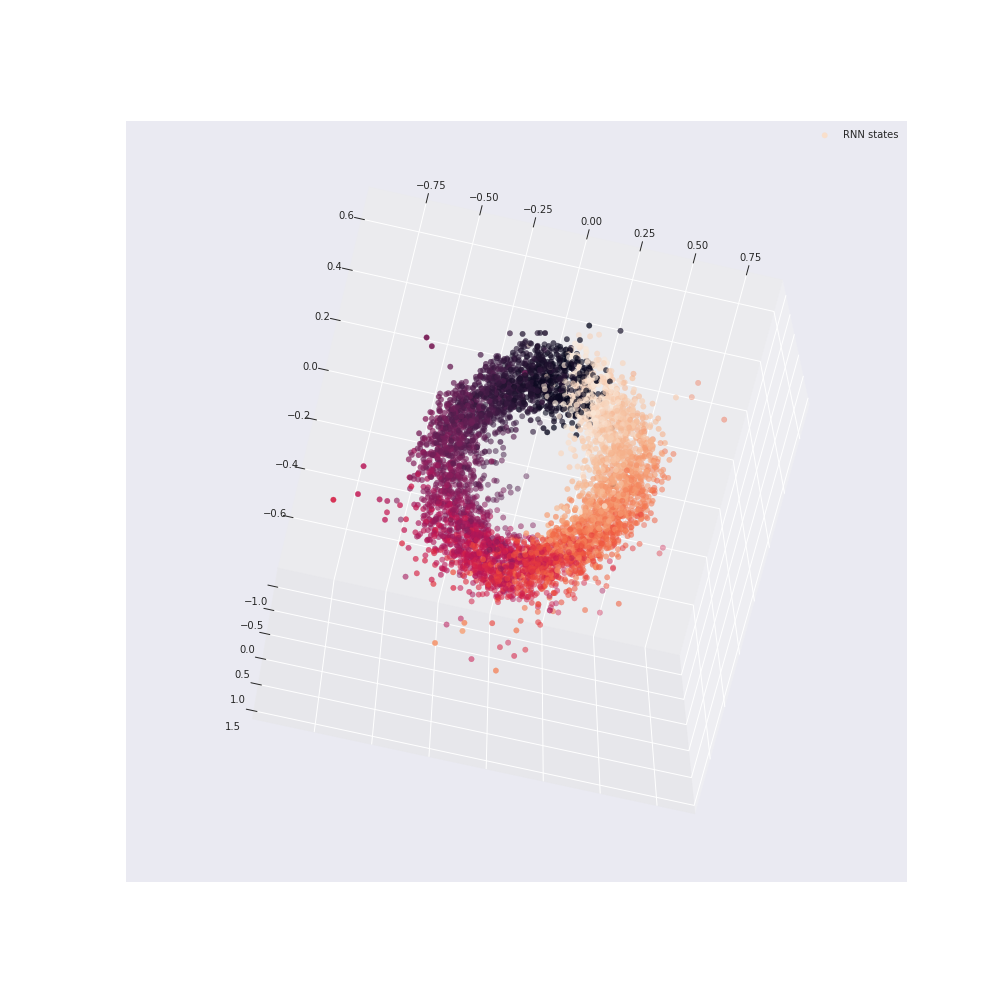

In [167]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rnn_embed[0, :], rnn_embed[1, :], rnn_embed[2, :], c=hd[idxs], s=30, label='RNN states')

plt.legend()

## Grid cells

In [14]:
index_size= 100
resolution = 50
maze_extents = 1.1

activations = np.zeros([512, resolution, resolution], dtype=np.float32) # (512, 32, 32)
counts  = np.zeros([resolution, resolution], dtype=np.int32)        # (32, 32)

# Stash activations and positions for later
g = np.zeros([index_size, flags.batch_size * flags.sequence_length, 512])
place_pos = np.zeros([index_size, flags.batch_size * flags.sequence_length, 2])

for index in range(index_size):
    g_batch, place_pos_batch = sess.run([model.g, model.target_pos])
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    
    g[index] = g_batch
    place_pos[index] = place_pos_batch
        
    for i in range(len(activations)):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        if x >=0 and x < resolution and z >=0 and z < resolution:
            counts[int(x), int(z)] += 1
            activations[:, int(x), int(z)] += g_batch[i, :]

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]

g = g.reshape([-1, 512])
place_pos = place_pos.reshape([-1, 2])

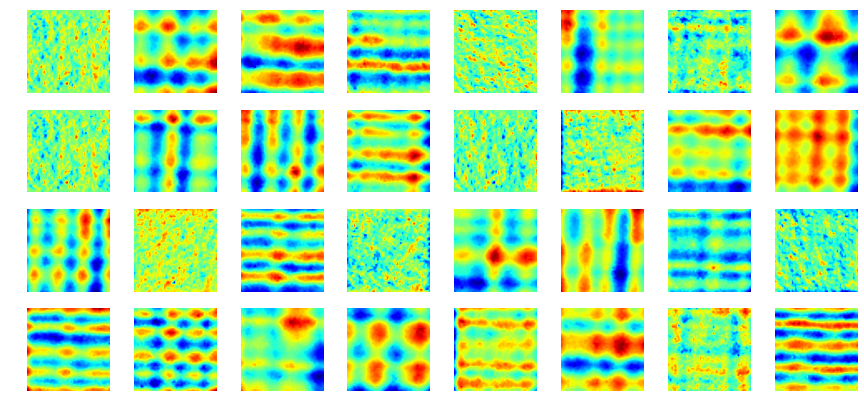

In [15]:
hidden_size = 32
# hidden_size = 64

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    plt.subplot(hidden_size//8, 8, 1 + i)
#     plt.title('Unit ' + str(i))
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off')    
plt.show()

## SVD

In [20]:
import scipy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [21]:
# Define rate map
rate_map = np.reshape(activations, [512, -1])
x = np.repeat(np.arange(resolution), resolution)
y = np.tile(np.arange(resolution), resolution)

In [22]:
# Perform SVD
idxs = np.random.randint(0, len(g), 5000)
X = g[idxs].T

N = X.shape[0]
K = X.shape[1]
M = 512
U, S, V = scipy.linalg.svd(X)

U = U[:,:M]

rm_embed = U.T.dot(rate_map)

<IPython.core.display.Javascript object>


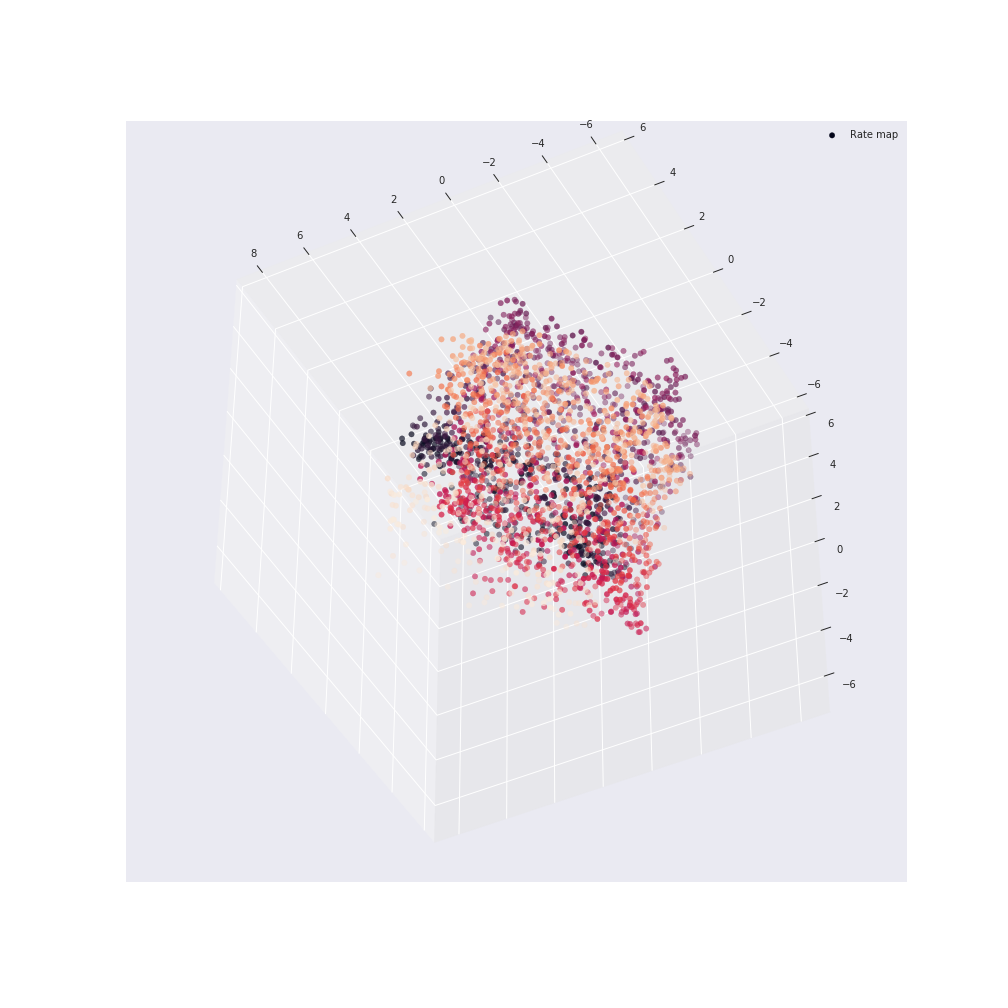

In [24]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
# h = ax.scatter(Xtilde[0, :], Xtilde[1, :], Xtilde[2, :],
#                c=place_pos[:,1], label='Neural states')


ax.scatter(rm_embed[0, :], rm_embed[1, :], rm_embed[2, :], c=x, s=30, label='Rate map')

plt.legend()

In [36]:
# Project manifold to neural space
g_embed = U.T.dot(g[idxs].T)

FR = U.dot(g_embed)

In [41]:
FR.shape

(512, 5000)

In [39]:
# Compute tuning curves
N = FR.shape[0]
resolution = 50
activations = np.zeros([N, resolution, resolution], dtype=np.float32)
counts  = np.zeros([resolution, resolution], dtype=np.int32)

j = 0
for i, idx in enumerate(idxs):
    pos_x = place_pos[idx,0]
    pos_y = place_pos[idx,1]
    x = (pos_x / np.max(place_pos[:,0])) * resolution
    y = (pos_y / np.max(place_pos[:,1])) * resolution
    if x > 0 and x < resolution and y > 0 and y < resolution:
        counts[int(x), int(y)] += 1
        activations[:, int(x), int(y)] += FR[:, i]
        
for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]

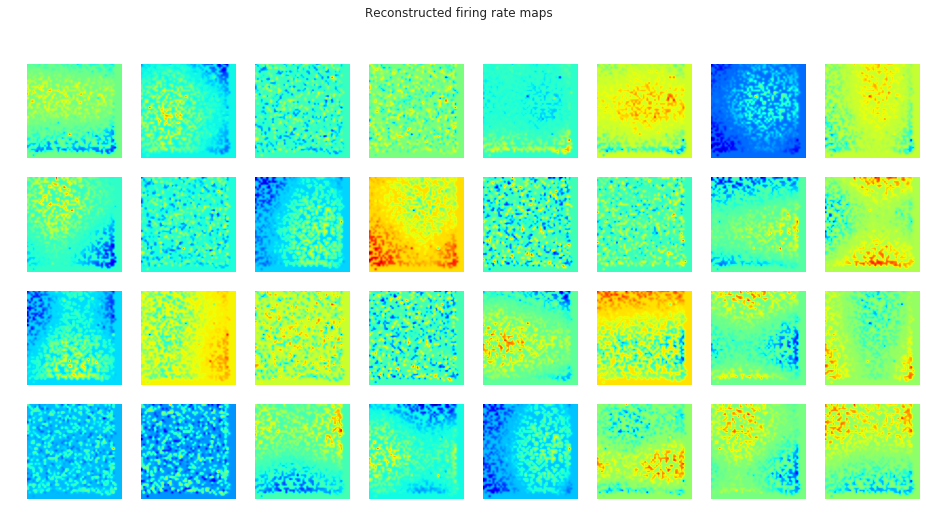

In [40]:
num_plots = 32
plt.figure(figsize=(16,int(num_plots / 4)))
for i in range(num_plots):
    plt.subplot(int(num_plots/8),8,i+1)
    plt.imshow(activations[i], interpolation='gaussian', cmap='jet')
    plt.suptitle('Reconstructed firing rate maps')
    plt.axis('off')

### Movie

In [25]:
idxs = np.arange(100)
traj_embed = U.T.dot(g[idxs].T)

In [26]:
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d.art3d import juggle_axes

In [27]:
%matplotlib notebook

<IPython.core.display.Javascript object>


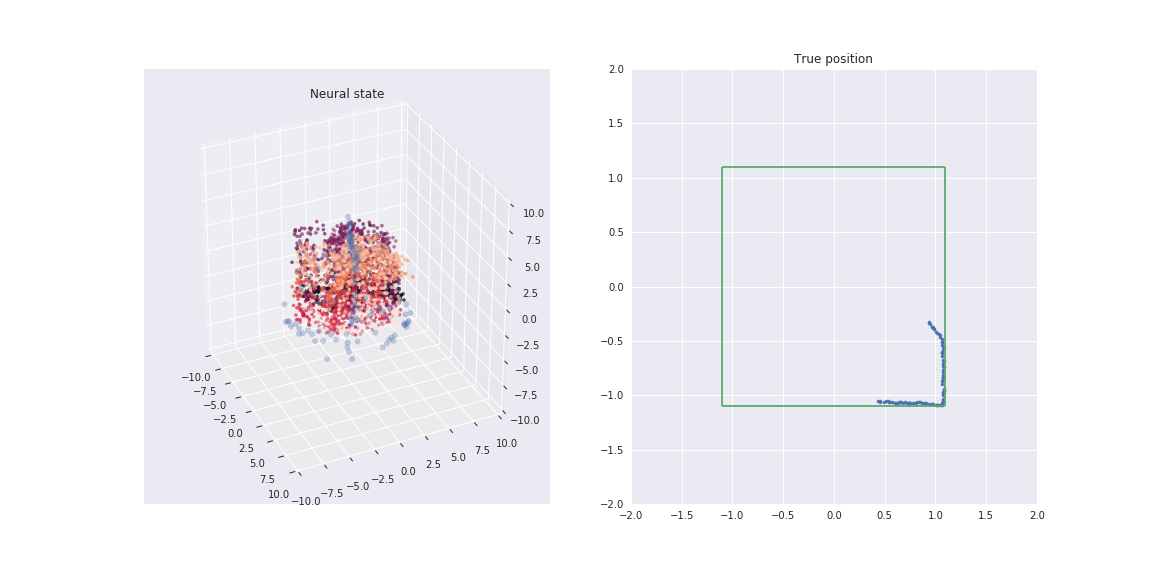

0
0
10
20
30
40
50
60
70
80
90


In [29]:
# Movie of trajectory on manifold
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

x = np.ones(100)*100
y = np.ones(100)*100
z = np.ones(100)*100

xc = np.repeat(np.arange(resolution), resolution)
ax.scatter(rm_embed[0, :], rm_embed[1, :], rm_embed[2, :], c=xc, s=10, label='Rate map')
scat = ax.scatter(x, y, z, s=30)

x2 = np.ones(100)*100
y2 = np.ones(100)*100
scat2 = ax2.scatter(x2, y2, s=10)

def update_plot(i, x, y, z, scat):
    if i % 10 == 0:
        print(i) 
    x[:i] = traj_embed[0, :i]
    y[:i] = traj_embed[1, :i]
    z[:i] = traj_embed[2, :i]
    scat._offsets3d = juggle_axes(x, y, z, 'z')
    
    x2[:i] = place_pos[:i,0]
    y2[:i] = place_pos[:i,1]
    scat2.set_offsets(np.concatenate([x2[:,None],y2[:,None]], axis=1))
    
    ax.azim -=0.5
    
    return scat, scat2,

ax.set_xlim3d([-10,10])
ax.set_ylim3d([-10,10])
ax.set_zlim3d([-10,10])
ax.view_init(30, 150)
ax.set_title('Neural state')

ax2.set_xlim([-2, 2])
ax2.set_ylim([-2, 2])
ax2.vlines([-1.1, 1.1], -1.1, 1.1, colors='C1')
ax2.hlines([-1.1, 1.1], -1.1, 1.1, colors='C1')
ax2.set_title('True position')

# Plot movie
ani = animation.FuncAnimation(fig, update_plot, frames=100,
                              fargs=(x, y, z, scat),
                              interval=100, blit=True)
HTML(ani.to_html5_video())

## Isomap

In [180]:
# project down to 10 dimensions
from sklearn.manifold import Isomap

embedding = Isomap(n_neighbors=5, n_components=3)

idxs = np.random.randint(0, len(g), 5000)
X_embedded = embedding.fit_transform(g[idxs])
rm_embed = embedding.transform(rate_map.T)

<IPython.core.display.Javascript object>


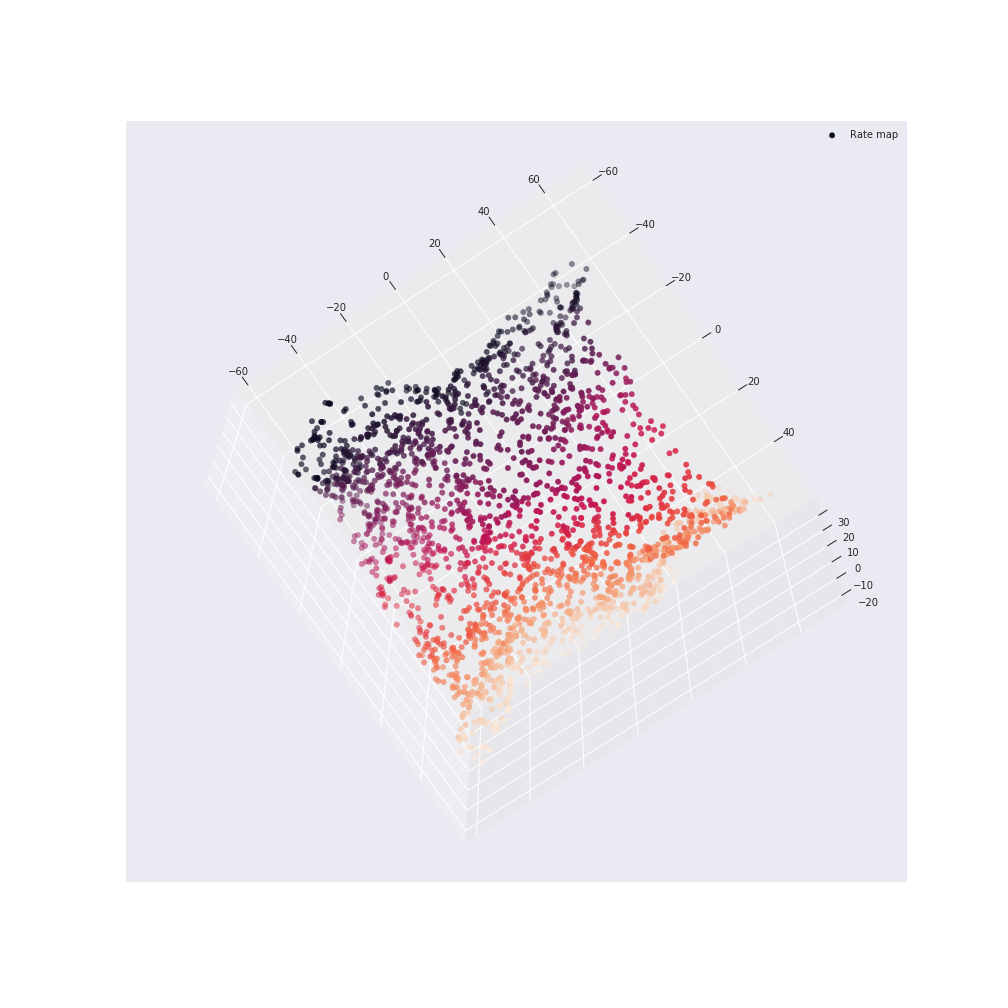

In [181]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=place_pos[idxs,1], label='Neural states')

ax.scatter(rm_embed[:,0], rm_embed[:,1], rm_embed[:,2], c=y, s=30, label='Rate map')

plt.legend()

## Reduced rank regression

In [30]:
# Construct inputs X
X = g

# Construct labels Y
x = place_pos[:,0]
y = place_pos[:,1]
x = np.round((x + 1.1) * 50 / 2.2).astype('uint8')
y = np.round((y + 1.1) * 50 / 2.2).astype('uint8')

x[x>49] = 49
y[y>49] = 49

Y = activations[:,x,y].T

In [31]:
# Define model
bottle_dim = 3
output_dim = 512

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(bottle_dim),
  tf.keras.layers.Dense(output_dim)
])

In [32]:
model.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

model.fit(X, Y, epochs=1)

Epoch 1/1
1000000/1000000 [==============================] - 42s 42us/step - loss: 0.0671 - acc: 0.1537


In [33]:
Ypred = model.predict(X)

rm = np.zeros([512,50,50])
counts = np.zeros([50,50])
for i in tqdm(range(len(Ypred))):
    x = place_pos[i,0]
    y = place_pos[i,1]
    x = (x + 1.1) * 50 / 2.2
    y = (y + 1.1) * 50 / 2.2
    if x >=0 and x < 50 and y >=0 and y < 50:
        rm[:, int(x), int(y)] += Ypred[i]
        counts[int(x), int(y)] += 1
    
for x in range(50):
    for y in range(50):
        if counts[x, y] > 0:
            rm[:, x, y] /= counts[x, y]

<IPython.core.display.Javascript object>


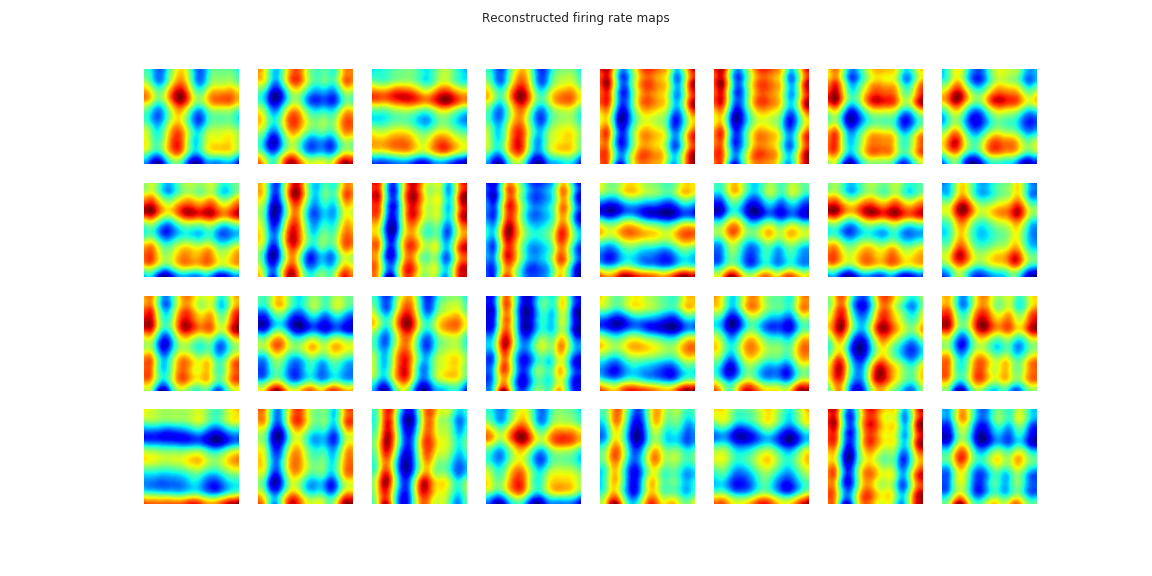

<IPython.core.display.Javascript object>


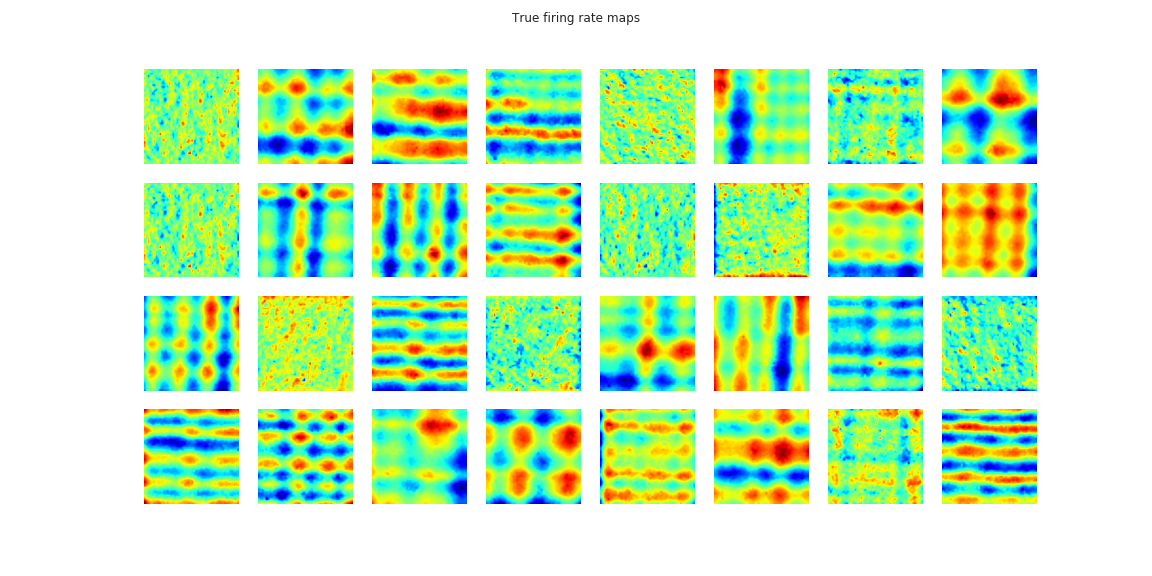

In [34]:
num_plots = 32
plt.figure(figsize=(16,int(num_plots / 4)))
for i in range(num_plots):
    plt.subplot(int(num_plots/8),8,i+1)
    plt.imshow(rm[i], interpolation='gaussian', cmap='jet')
    plt.suptitle('Reconstructed firing rate maps')
    plt.axis('off')
    
plt.figure(figsize=(16,int(num_plots / 4)))
for i in range(num_plots):
    plt.subplot(int(num_plots/8),8,i+1)
    plt.imshow(activations[i], interpolation='gaussian', cmap='jet')
    plt.suptitle('True firing rate maps')
    plt.axis('off')

In [35]:
# Get weights
P, b1 = model.layers[0].get_weights()
R, b2 = model.layers[0].get_weights()

<IPython.core.display.Javascript object>


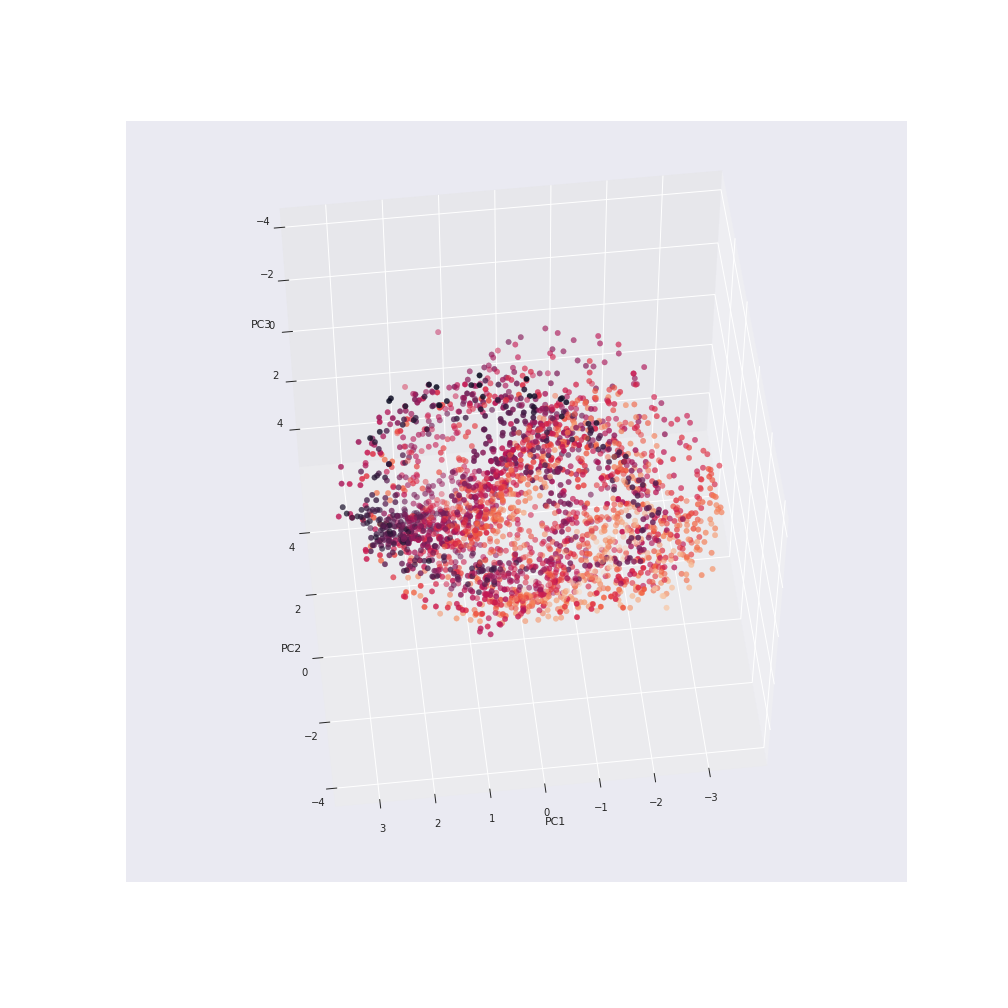

Text(0.5,0,'PC3')

In [36]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

# X_embed = X.dot(P)
# # idxs = np.random.randint(0, len(X), 5000)
# idxs = np.arange(1000)
# h = ax.scatter(X_embed[idxs,0], X_embed[idxs,1], X_embed[idxs,2], c=place_pos[idxs,0], s=30)

rm_embed = rate_map.T.dot(P)
x = np.repeat(np.arange(resolution), resolution)
y = np.tile(np.arange(resolution), resolution)
ax.scatter(rm_embed[:,0], rm_embed[:,1], rm_embed[:,2], c=rate_map[1], s=30)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Distances

In [113]:
from skimage.feature import peak_local_max
import cv2

In [11]:
import scores

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
coord_range=((-1.1, 1.1), (-1.1, 1.1))
masks_parameters = zip(starts, ends.tolist())
scorer = scores.GridScorer(50, coord_range, masks_parameters)

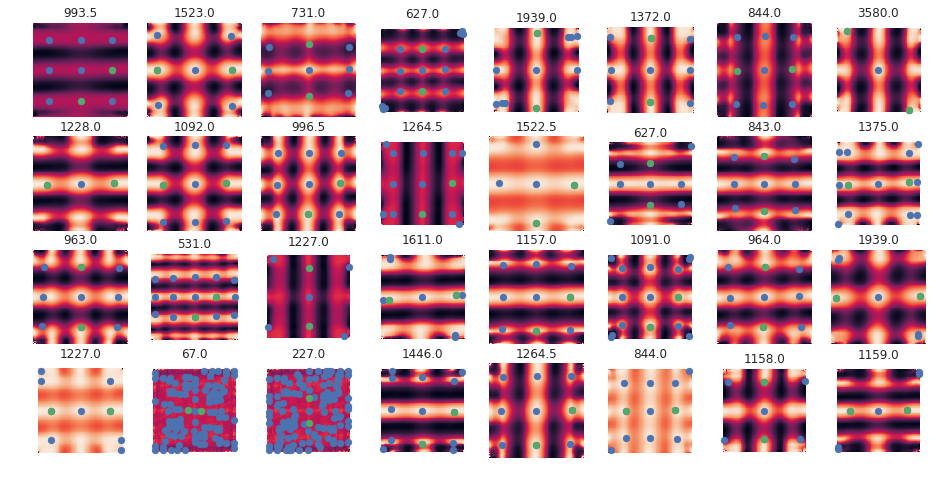

In [124]:
plt.figure(figsize=(16,8))
i = 0
j = 0

kernel = np.ones((5,5),np.float32)/25

while j < 32:
    out = scorer.get_scores(activations[i])
    score_60, score_90, max_60_mask, max_90_mask, sac = out
    if score_90 > 0.6:
        
        sacfilt = cv2.filter2D(sac,-1,kernel)
        coords = peak_local_max(sacfilt)
        dists = np.sum((coords - center)**2, axis=1)
        dists_sort = np.argsort(dists)

        plt.subplot(4,8,j+1)
        plt.imshow(sac)
        plt.scatter(coords[:,0], coords[:,1])
        plt.scatter(coords[dists_sort[1:3],0], coords[dists_sort[1:3],1])
        plt.title(np.mean(dists[dists_sort[1:3]]))
        plt.axis('off')
        
        j+=1
        
    i+=1

In [125]:
center = [50,50]

spacings = []
for i in range(len(activations)):
    out = scorer.get_scores(activations[i])
    score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(activations[i])
    coords = peak_local_max(sac, min_distance=2)
    if score_90 > 0.6:
        dists = np.sum((coords - center)**2, axis=1)
        dists_sort = np.sort(dists)
        spacing = np.mean(dists_sort[1:3])
        print(spacing)
        spacings = np.append(spacings, spacing)

963.0
1523.0
731.0
627.0
1939.0
1372.0
843.0
3202.0
1228.0
1092.0
996.5
1264.5
1522.5
678.0
786.0
1375.0
963.0
531.0
1227.0
1611.0
1157.0
1057.5
903.0
1939.0
1227.0
82.0
71.5
1446.0
1229.0
844.0
1091.0
1159.0
962.0
555.0
1159.0
1026.0
1092.0
651.5


/home/ec2-user/grid_cells/scores.py:138: RuntimeWarning: divide by zero encountered in true_divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


843.0
1227.0
1372.0
843.0
1228.0
531.0
1227.0
1159.0
38.0
1158.0
1026.0
1191.5
1228.0
963.0
123.0
1160.0
1027.0
1523.0
1026.0
1091.0
963.0
1333.5
1522.5
1372.0
786.0
963.0
82.0
1407.5
1091.0
1158.0
1372.0
381.5
902.0
1123.5
71.5
486.0
1159.0
1027.0
1158.0
1159.0
1447.0
402.0
1027.0
1158.0
1158.0
844.0
578.0
1643.0
1333.5
1026.0
902.0
963.0
1523.0
1158.0
786.0
1410.5
1026.0
902.0
1026.0
963.0
486.0
1299.0
578.0
1027.0
964.0
731.0
962.0
553.5
786.0
1091.0
1092.0
1092.0
1091.0
1372.0
273.5
843.0
443.0
1091.0
902.0
1157.0
1192.5
1026.0
1157.0
1092.0
1092.0
627.0
964.0
902.0
1091.0
703.5
1027.0
1027.0
1057.5
900.5
1159.0
1333.5
1091.0
1231.0
902.0
1409.0
1123.5
1227.0
964.0
843.0
531.0
963.0
486.0
1091.0
601.5
1263.0
1227.0
843.0
1227.0
732.0
626.0
1372.0
1228.0
963.0
45.5
902.0
1228.0
1445.0
307.5
1447.0
1057.5
1299.0
463.5
1228.0
1125.0
1228.0
1227.0
993.5
1092.0
57.5
1446.0
1095.0
963.5
703.5
1372.0
963.0
1026.0
1026.0
1158.0
902.0
678.0
732.0
843.0
1091.0
1091.0
1852.0
1027.0
843.0
730.

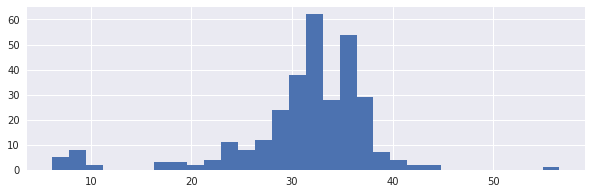

In [126]:
plt.figure(figsize=(10,3))
plt.hist(np.sqrt(spacings), bins=30)
plt.show()

## Persistence homology

In [128]:
from ripser import ripser, plot_dgms
from scipy.spatial.distance import pdist, squareform

In [132]:
idxs = np.random.randint(0, len(g), 500)
X_full = g[idxs]

# Compute pairwise distances
pair_dists_vec = pdist(X_full)
pair_dists = squareform(pair_dists_vec)

# Threshold 1st percentile distance 
thresh_dist = np.percentile(pair_dists_vec, 1)

# Find bottom 20th percentile of distr. of number of neighbors
num_neighbors = np.sum(pair_dists > thresh_dist, axis=1)
thresh_neighbors = np.percentile(num_neighbors, 20)
inlier_idxs = np.where(num_neighbors > thresh_neighbors)

# Remove outliers
X = X_full[inlier_idxs]

In [183]:
# Alternatively, use the rate map
rate_map = np.reshape(activations, [512, -1])
X = rate_map.T

In [184]:
# project down to 10 dimensions
from sklearn.manifold import Isomap

embedding = Isomap(n_neighbors=20, n_components=10)
X_embedded = embedding.fit_transform(X)

Text(0.5,0,'PC3')

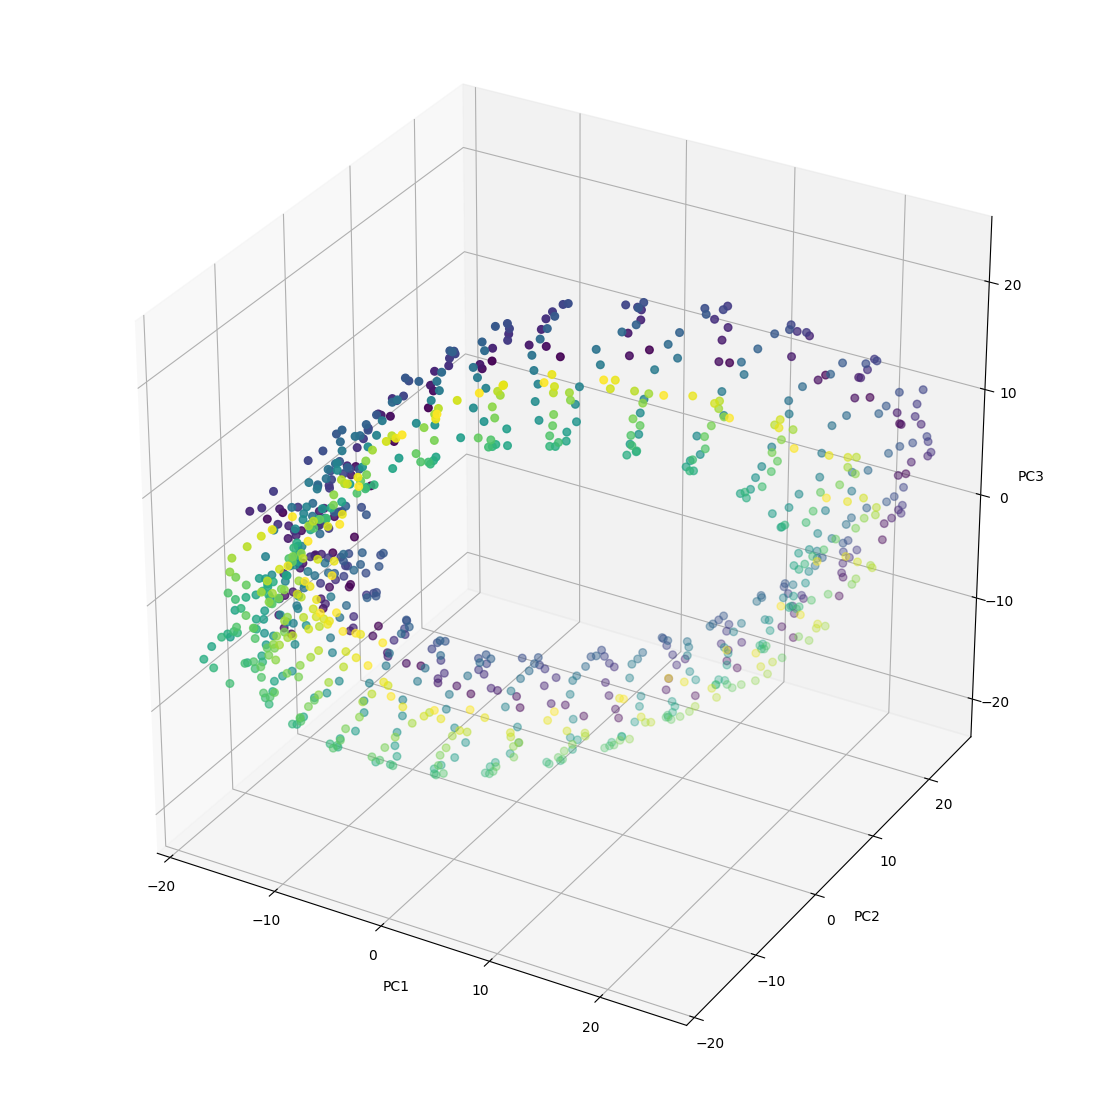

In [185]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

# X_embed = X.dot(P)
# # idxs = np.random.randint(0, len(X), 5000)
# idxs = np.arange(1000)
# h = ax.scatter(X_embed[idxs,0], X_embed[idxs,1], X_embed[idxs,2], c=place_pos[idxs,0], s=30)

# rm_embed = rate_map.T.dot(P)
x = np.repeat(np.arange(resolution), resolution)
y = np.tile(np.arange(resolution), resolution)
ax.scatter(X_embedded[:,1], X_embedded[:,1], X_embedded[:,2], c=x, s=30)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

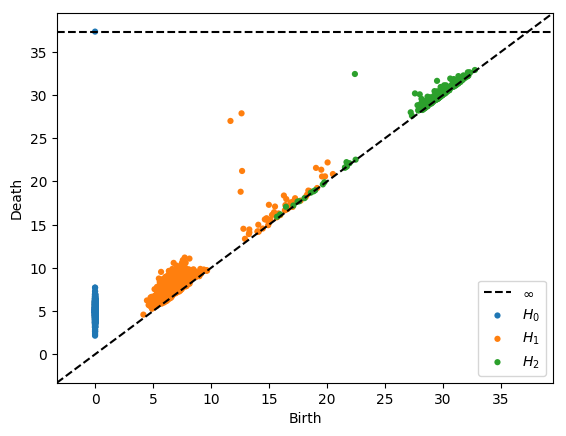

In [186]:
res = ripser(X_embedded, maxdim=2)
diagrams = res['dgms']
plot_dgms(diagrams, show=True)

<BarContainer object of 968 artists>

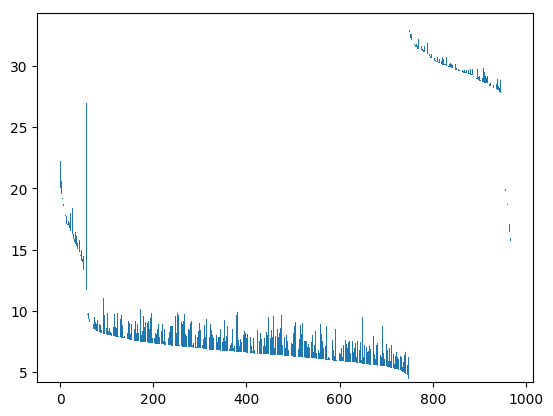

In [188]:
bottoms = np.concatenate([diagrams[1][:,0], diagrams[2][:,0]])
tops = np.concatenate([diagrams[1][:,1], diagrams[2][:,1]])
heights = tops - bottoms

plt.bar(np.arange(len(heights)), heights, bottom=bottoms)